In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
from copy import copy
from scipy import stats,signal
from ptsa.data.timeseries import TimeSeries
import time
import mat73 # this loads .mat files as dicts

sys.path.append('/u/home/j/jsakon/johnModules')
%load_ext autoreload
%autoreload
from general import *
import neuralynx_io

# You can remove all the annoying warnings above by running these first:

import warnings
warnings.filterwarnings("ignore", message="Unable to parse")
warnings.filterwarnings("ignore", message="Invalid")

# load macro LFP from neuralynx (obviously you'll have to change path to where you download the .zips from Vwani_movie folder)

In [2]:
begin_time = time.time()

desired_samplerate = 1000 # Hz

# p555 test load of pre-sleep data
base_fn = '/u/project/ifried/jsakon/brandon_test/' # you'll have to change this obviously to where you stored the data on Hoffman
elecs = ['RA']

nsc_nums = np.arange(0,3)+1 # will have to glob directories to do this right but for now just grab the first 3 contacts on this macro
lfp_mat = []
for elec in elecs:
    for nsc_num in nsc_nums:
        fn = base_fn + elec + str(nsc_num) + '.ncs'
        print(fn)
        lfp_mat = superVstack(lfp_mat,neuralynx_io.load_ncs(fn)['data']) # superVstack is a helper file in the general.py that John made
    

/u/project/ifried/jsakon/brandon_test/RA1.ncs
/u/project/ifried/jsakon/brandon_test/RA2.ncs
/u/project/ifried/jsakon/brandon_test/RA3.ncs


In [3]:
np.shape(lfp_mat)
print('Length of data: '+str(np.shape(lfp_mat)[1]/neuralynx_io.load_ncs(fn)['sampling_rate'])+' seconds')

(3, 7286784)

Length of data: 3643.392 seconds


## make PTSA (yum)

In [4]:
lfp_mat = signal.decimate(lfp_mat,int(neuralynx_io.load_ncs(fn)['sampling_rate']/desired_samplerate)) # Only if you're looking to decimate micros from 32kHz
time_in_sec = np.linspace(1, np.shape(lfp_mat)[1], np.shape(lfp_mat)[1]) / desired_samplerate
lfp_mat = TimeSeries(lfp_mat,
                dims=('channel', 'time'),
                coords={'channel':nsc_nums,
                        'time':time_in_sec,
                        'samplerate':desired_samplerate})
print('Shape of LFP matrix (channel X time):')
print(np.shape(lfp_mat))

Shape of LFP matrix (channel X time):
(3, 3643392)


## typical processing of LFP (left commented examples of how this looks with rhino data...big difference is no longer have events dimension)

In [5]:
from ptsa.data.filters import ButterworthFilter
from ptsa.data.filters import MorletWaveletFilter
from scipy.stats import zscore

buf = 1000  #to remove edge effects during wavelet convolution
spec_freqs = np.logspace(np.log10(3), np.log10(180), 8) # spectral frequencies used in Ezzyat et al 2018
filt_range = [58., 62.] # don't worry about 120 and 180 Hz harmonics since not sampled in spec_freqs

lfp_mat = ButterworthFilter(freq_range=filt_range, filt_type='stop', order=4).filter(timeseries=lfp_mat)

#     # downsample EEG...could do this if necessary to save processing power since we're going to 
#     # bin down to 33.3 ms bins eventually anyway
#     eeg_ptsa = eeg_ptsa.resampled(resampled_rate=500.)

#Get spectral power
pow_wavelet = MorletWaveletFilter(freqs=spec_freqs, width=5, output='power').filter(timeseries=lfp_mat) # , cpus=2
#output is freqs, events, elecs, and time
# e.g. (8, 240, 141, 700) is 8 logarithmically spaced freqs from 3:180, 240 is trials, 141 elecs, 700 samples (1400 ms each typically)

#remove buffer period added to beginning and end of each trial
#     pows = pow_wavelet.data[:, :, :, int((buf/1000.)*sr):-1*int((buf/1000.)*sr)]  
#     pows = pow_wavelet.isel(time = ((pow_wavelet.time>=start_time) & (pow_wavelet.time<=end_time)))
#     pows = np.log10(pows)

pow_wavelet = np.log10(pow_wavelet)

#     #Average power across the whole interval
#     avg_pows = pows.mean('time')
#     avg_pows = np.squeeze(avg_pows)

z_pows = (pow_wavelet-pow_wavelet.mean('time'))/pow_wavelet.std('time')

#     z_pows = zscore(avg_pows, axis=1)  #z-score power values across events (important to do within-session)
#     # freqs X trials X electrodes (e.g. 8 X 240 X 141)
#     z_pows = (avg_pows-avg_pows.mean('event'))/avg_pows.std('event')

print(np.shape(z_pows)) # output is frequency X channel X time
# append frequencies together to create time X feature matrix
z_pows = np.array(z_pows).swapaxes(0,2).swapaxes(1,2).reshape(np.shape(pow_wavelet)[2], -1)
print(np.shape(z_pows))


CPP total time wavelet loop:  3.6847405433654785
(8, 3, 3643392)
(3643392, 24)


Seconds since started compiling =  19.71459674835205


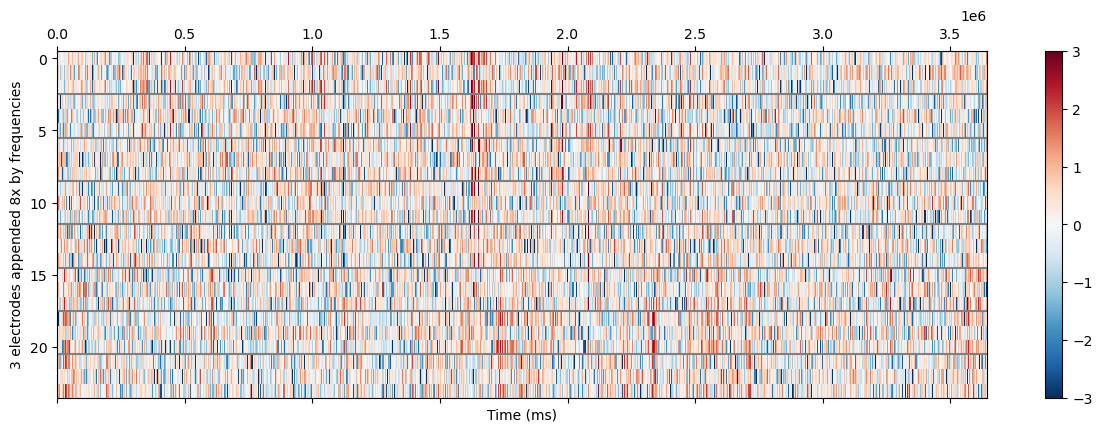

In [6]:
elec_num = np.shape(pow_wavelet)[1]
plt.figure(figsize=(15, 4.5)); ax=plt.subplot(111)
ax1 = ax.matshow(z_pows.swapaxes(0,1), aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
plt.ylabel(str(elec_num)+' electrodes appended 8x by frequencies')
plt.xlabel('Time (ms)')
for ln in range(8):    
    plt.plot([0, len(z_pows)],[elec_num*ln-0.5, elec_num*ln-0.5],color=(0.5,0.5,0.5)) 
plt.colorbar(ax1)
print("Seconds since started compiling = ", time.time()-begin_time)
a=1;